# Plotting land cover raster data with rioxarray and Matplotlib

Data used:

Abera, Temesgen Alemayheu; Vuorinne, Ilja; Munyao, Martha; Pellikka, Petri;
Heiskanen, Janne (2021), "Taita Taveta County, Kenya - 2020 Land cover map
and reference database", Mendeley Data, V2, doi:
[10.17632/xv24ngy2dz.2](https://doi.org/10.17632/xv24ngy2dz.2) - CC-BY-4.0

In [1]:
# import libraries
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from zipfile import BadZipFile, ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import rioxarray as rxr
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))
os.makedirs(os.path.join("data", "basemaps"), exist_ok=True)

In [3]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-11-15 14:55:23.898690+00:00


In [4]:
KNOWN_HASH = None
URL = (
    "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/"
    "xv24ngy2dz-2.zip"
)
FILE_NAME = "kenya_land_cover.zip"
SUB_DIR = os.path.join("data", "kenya_land_cover")
DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)
os.makedirs(SUB_DIR, exist_ok=True)

In [5]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL, known_hash=KNOWN_HASH, fname=FILE_NAME, path=SUB_DIR
    )

    with open(
        os.path.join(SUB_DIR, f"{FILE_NAME[:-4]}.txt"), "w", encoding="utf-8"
    ) as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

SHA256 hash of downloaded file: 6b8de324bed4cc2339989184ec2b2b985bbaba691a3885b287551f0f4646d8c3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [6]:
with open(f"{DATA_FILE[:-4]}.txt") as f:
    print(f.read())

Data downloaded on: 2023-11-15 14:55:33.050782+00:00
Download URL: https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xv24ngy2dz-2.zip


In [7]:
# list of files in the ZIP archive
ZipFile(DATA_FILE).namelist()

['xv24ngy2dz-2/Data/Land cover map /Landcover-cMfoO1.tif',
 'xv24ngy2dz-2/Data/Land cover map /ColorCode-ni1SIo.qml',
 'xv24ngy2dz-2/Data/Land cover map /Info-UBC9RP.txt',
 'xv24ngy2dz-2/Data/Reference Database for Accuracy Assessment/File.zip',
 'xv24ngy2dz-2/Data/Reference Database for Classification/File.zip']

In [8]:
# extract the archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(SUB_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

In [9]:
# define paths to the TIF and QML files
for i in ZipFile(DATA_FILE).namelist():
    if i.endswith(".tif"):
        raster_file = os.path.join(SUB_DIR, i)
    elif i.endswith(".qml"):
        style_file = os.path.join(SUB_DIR, i)

In [10]:
landcover = rxr.open_rasterio(raster_file, chunks=300, masked=True)

In [11]:
landcover

<xarray.DataArray (band: 1, y: 5400, x: 6068)>
dask.array<open_rasterio-e895df41e774264508b22627f52fd381<this-array>, shape=(1, 5400, 6068), dtype=float32, chunksize=(1, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 37.58 37.58 37.58 37.58 ... 39.22 39.22 39.22 39.22
  * y            (y) float64 -2.683 -2.683 -2.683 ... -4.137 -4.138 -4.138
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  1.218022624508617
    STATISTICS_MAXIMUM:      14
    STATISTICS_MEAN:         5.580012913879
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.1036406228971
    scale_factor:            1.0
    add_offset:              0.0

In [12]:
landcover.rio.resolution()

(0.00026949458520105445, -0.00026949458520105445)

In [13]:
landcover.rio.bounds()

(37.583984352, -4.138089356, 39.21927749499999, -2.682818595914306)

In [14]:
landcover.rio.crs

CRS.from_epsg(4326)

In [16]:
# get unique value count for the raster
uniquevals = pd.DataFrame(np.unique(landcover, return_counts=True)).transpose()

# assign column names
uniquevals.columns = ["value", "count"]

# drop row(s) with NaN
uniquevals.dropna(inplace=True)

# convert value column to string (this is required for merging later)
uniquevals["value"] = uniquevals["value"].astype(int).astype(str)

In [17]:
uniquevals

,value,count
0,1,16621.0
1,2,33046.0
2,3,33286.0
3,4,981030.0
4,5,9219689.0
5,6,7721553.0
6,7,124588.0
7,8,871990.0
8,9,75661.0
9,10,10556.0


In [18]:
# read the QGIS style file containing the legend entries
tree = ET.parse(style_file)
root = tree.getroot()

# extract colour palette
pal = {}

for palette in root.iter("paletteEntry"):
    pal[palette.attrib["value"]] = palette.attrib

# generate data frame from palette dictionary
legend = pd.DataFrame.from_dict(pal).transpose()
legend = pd.DataFrame(legend)

# drop alpha column
legend.drop(columns="alpha", inplace=True)

# convert value column to string (this is required for merging later)
legend["value"] = legend["value"].astype(str)

In [19]:
legend

,value,label,color
1,1,Montane forest,#6ed277
2,2,Plantation forest,#4d7619
3,3,Riverine forest,#27f90c
4,4,Thicket,#fd8e07
5,5,Shrubland,#fac597
6,6,Grassland,#aaec85
7,7,Agroforestry,#4df3ef
8,8,Cropland,#f9ed25
9,9,Sisal,#840bfe
10,10,Builtup,#833023


In [20]:
# merge unique values data frame with legend
uniquevals = uniquevals.merge(legend, on="value")

# calculate percentage based on count
uniquevals["percentage"] = (
    uniquevals["count"] / uniquevals["count"].sum() * 100
)
uniquevals["percentage"] = uniquevals["percentage"].astype(int)

# sort by count
uniquevals.sort_values("count", ascending=False, inplace=True)

In [21]:
uniquevals

,value,count,label,color,percentage
4,5,9219689.0,Shrubland,#fac597,47
5,6,7721553.0,Grassland,#aaec85,40
3,4,981030.0,Thicket,#fd8e07,5
7,8,871990.0,Cropland,#f9ed25,4
6,7,124588.0,Agroforestry,#4df3ef,0
12,13,89317.0,Baresoil,#ee15ca,0
8,9,75661.0,Sisal,#840bfe,0
11,12,73355.0,Wetland,#4dc4f3,0
10,11,34500.0,Waterbody,#3630ee,0
2,3,33286.0,Riverine forest,#27f90c,0


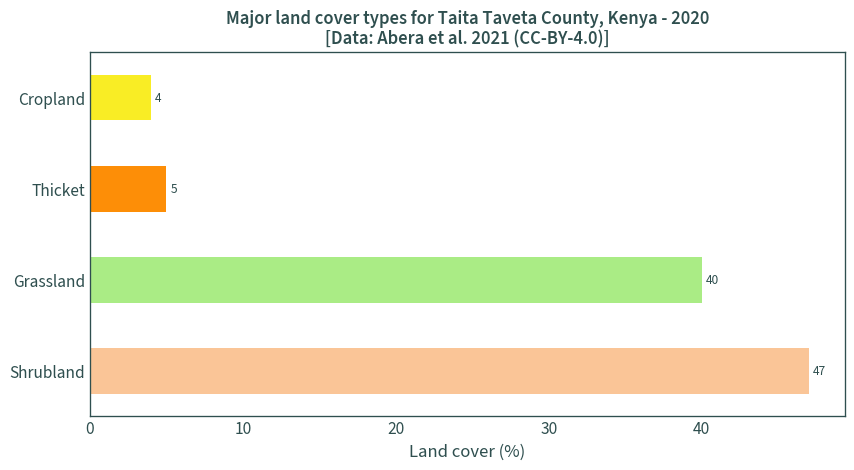

In [22]:
# plot the major land cover types, i.e. percentage > 0
mask = uniquevals["percentage"] > 0
uniquevals_sig = uniquevals[mask]

ax = uniquevals_sig.plot.barh(
    x="label",
    y="percentage",
    legend=False,
    figsize=(9, 5),
    color=uniquevals_sig["color"],
)

ax.bar_label(ax.containers[0], padding=3)
plt.title(
    "Major land cover types for Taita Taveta County, Kenya - 2020"
    + "\n[Data: Abera et al. 2021 (CC-BY-4.0)]"
)
plt.ylabel("")
plt.xlabel("Land cover (%)")
plt.tight_layout()
plt.show()

In [23]:
# convert values to integer and sort
uniquevals["value"] = uniquevals["value"].astype(int)
uniquevals.sort_values("value", inplace=True)

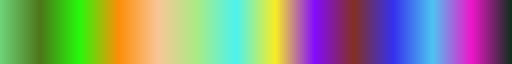

In [24]:
# create a continuous colourmap for the plot
colours = list(uniquevals["color"])
nodes = np.array(uniquevals["value"])
# normalisation
nodes = (nodes - min(nodes)) / (max(nodes) - min(nodes))
colours = LinearSegmentedColormap.from_list("LCM", list(zip(nodes, colours)))
colours

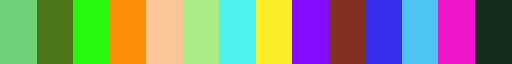

In [25]:
# create a discrete colourmap for the legend
col_discrete = ListedColormap(list(uniquevals["color"]))
col_discrete

In [26]:
xmin, ymin, xmax, ymax = landcover.rio.bounds()

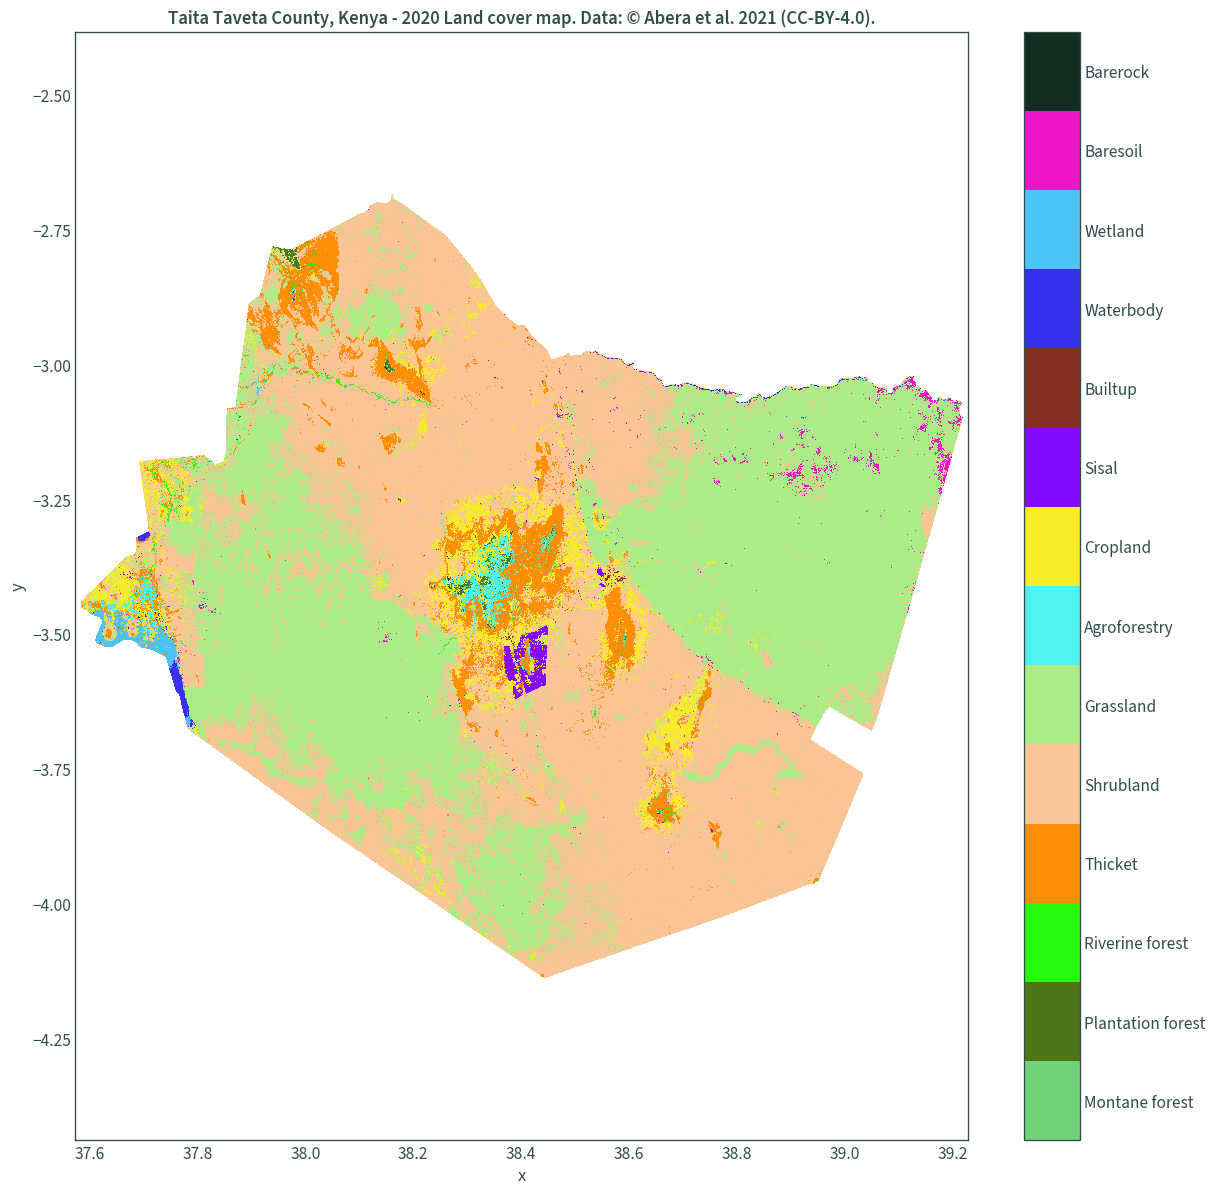

In [27]:
# create a dummy plot for the discrete colour map as the legend
img = plt.figure(figsize=(15, 15))
img = plt.imshow(np.array([[0, len(uniquevals)]]), cmap=col_discrete)
img.set_visible(False)

# assign the legend's tick labels
ticks = list(np.arange(0.5, len(uniquevals) + 0.5, 1))
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(list(uniquevals["label"]))

landcover.plot(add_colorbar=False, cmap=colours)

plt.axis("equal")
plt.xlim(xmin - 0.01, xmax + 0.01)
plt.ylim(ymin - 0.01, ymax + 0.01)

plt.title(
    "Taita Taveta County, Kenya - 2020 Land cover map. "
    "Data: © Abera et al. 2021 (CC-BY-4.0)."
)

plt.show()

In [28]:
# clip data into a smaller subset to demonstrate further plotting capabilities
# use web mercator projection
CRS = 3857

In [29]:
# 20k meter buffer at the centre
mask = gpd.GeoSeries(
    gpd.points_from_xy(
        [xmin + (xmax - xmin) / 2],
        [ymin + (ymax - ymin) / 2],
        crs=landcover.rio.crs,
    )
    .to_crs(CRS)
    .buffer(20000)
    .to_crs(landcover.rio.crs)
)

In [30]:
mask

0    POLYGON ((38.58129 -3.41045, 38.58043 -3.42803...
dtype: geometry

In [31]:
mask.total_bounds

array([38.22196787, -3.58978183, 38.58129398, -3.23109267])

In [32]:
mask.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
landcover.rio.clip(mask)

<xarray.DataArray (band: 1, y: 1331, x: 1334)>
dask.array<getitem, shape=(1, 1331, 1334), dtype=float32, chunksize=(1, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 38.22 38.22 38.22 38.22 ... 38.58 38.58 38.58 38.58
  * y            (y) float64 -3.231 -3.231 -3.232 -3.232 ... -3.589 -3.589 -3.59
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  1.218022624508617
    STATISTICS_MAXIMUM:      14
    STATISTICS_MEAN:         5.580012913879
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.1036406228971
    scale_factor:            1.0
    add_offset:              0.0

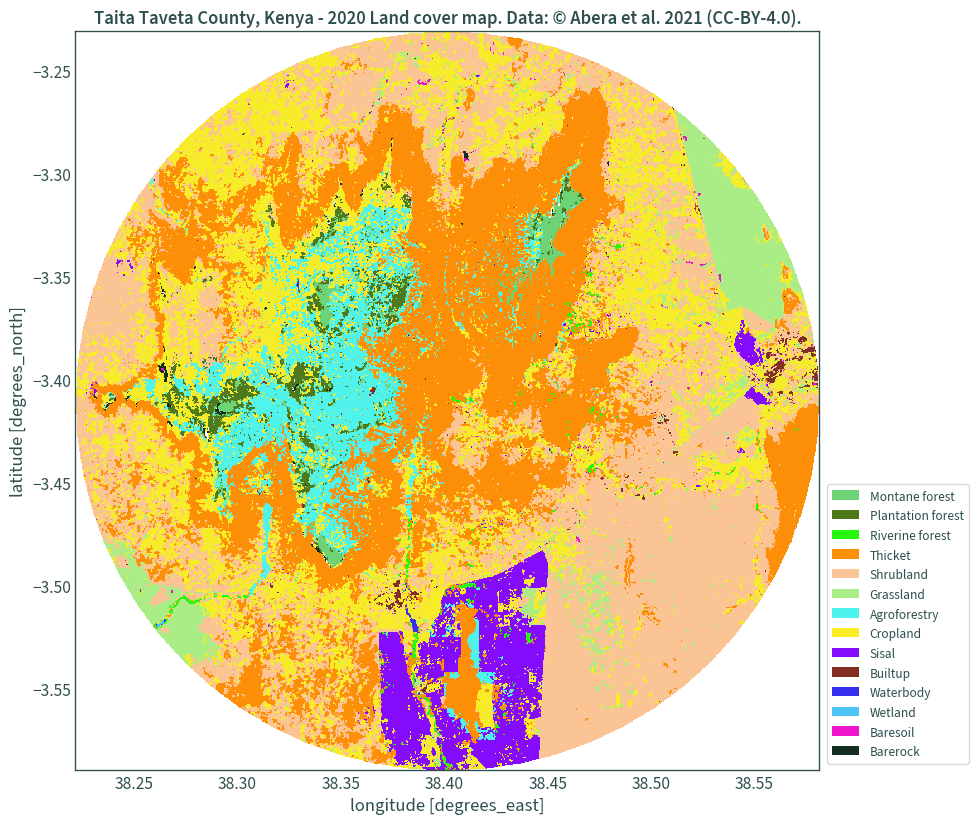

In [34]:
# use legend handles for better legends
fig, ax = plt.subplots(figsize=(10, 10))
landcover.rio.clip(mask).plot(add_colorbar=False, cmap=colours, ax=ax)

legend_handles = []
for color, label in zip(list(uniquevals["color"]), list(uniquevals["label"])):
    legend_handles.append(mpatches.Patch(facecolor=color, label=label))

ax.legend(handles=legend_handles, loc="lower right", bbox_to_anchor=(1.21, 0))

plt.title(
    "Taita Taveta County, Kenya - 2020 Land cover map. "
    "Data: © Abera et al. 2021 (CC-BY-4.0)."
)

plt.show()

In [35]:
xmin, ymin, xmax, ymax = landcover.rio.reproject(CRS).rio.bounds()

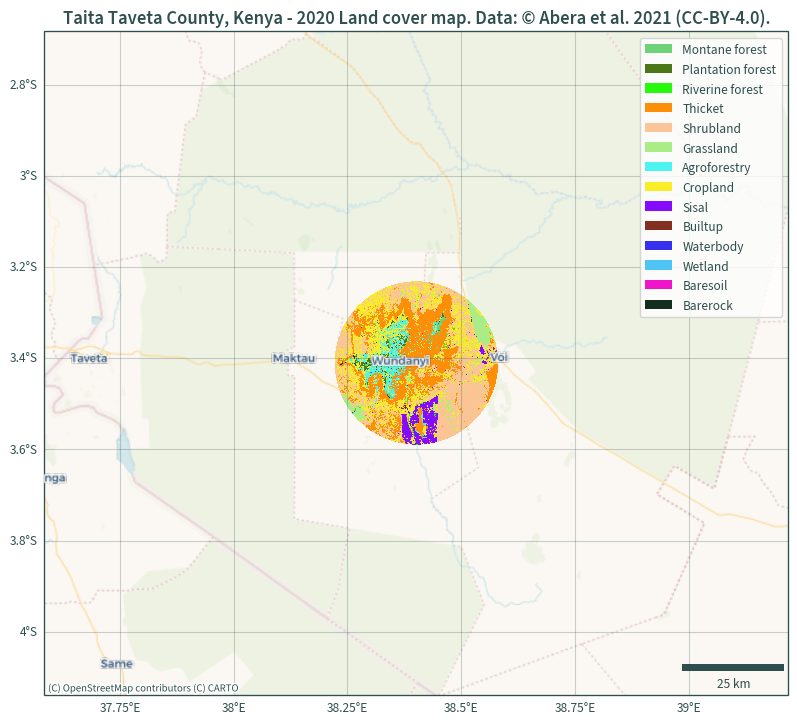

In [36]:
# with better legends, basemap, scalebar, and gridlines
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.epsg(CRS))
landcover.rio.clip(mask).rio.reproject(CRS).plot(
    add_colorbar=False, cmap=colours, ax=ax
)

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)

cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels)
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerOnlyLabels)

legend_handles = []
for color, label in zip(list(uniquevals["color"]), list(uniquevals["label"])):
    legend_handles.append(mpatches.Patch(facecolor=color, label=label))

ax.legend(handles=legend_handles)

ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=0.25, color="darkslategrey"
)

ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)

plt.title(
    "Taita Taveta County, Kenya - 2020 Land cover map. "
    "Data: © Abera et al. 2021 (CC-BY-4.0)."
)

plt.show()